In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

import networkx as nx

### Введение
Цель — исследовать методы анализа ассоциативных правил (Apriori и FP-Growth) на датасете транзакций (Groceries). 
Задачи: загрузка и предобработка данных, EDA (распределение длин транзакций, уникальные товары), применение Apriori и FP-Growth, исследование влияния параметров (min_support, min_confidence), алгоритмический подбор минимальной поддержки по размеру наборов, визуализация правил и выводы.

In [32]:
all_data = pd.read_csv('groceries.csv', on_bad_lines='skip')
all_data

,citrus fruit,semi-finished bread,margarine,ready soups
0,tropical fruit,yogurt,coffee,NaN
1,whole milk,NaN,NaN,NaN
2,pip fruit,yogurt,cream cheese,meat spreads
3,other vegetables,whole milk,condensed milk,long life bakery product
4,rolls/buns,NaN,NaN,NaN
...,...,...,...,...
6100,yogurt,long life bakery product,NaN,NaN
6101,pork,frozen vegetables,pastry,NaN
6102,ice cream,long life bakery product,specialty chocolate,specialty bar
6103,cooking chocolate,NaN,NaN,NaN


In [33]:
file_path = "C:\\Users\\Днс\\Desktop\\jupyter\\groceries.csv"
with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.read().splitlines()
transactions = []
for line in lines:
    items = [item.strip() for item in line.split(',') if item.strip()]
    transactions.append(items)
print(f"Количество транзакций: {len(transactions)}")
print("Примеры первых 5 транзакций:")
for t in transactions[:5]:
    print(t)

Количество транзакций: 9835
Примеры первых 5 транзакций:
['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']
['tropical fruit', 'yogurt', 'coffee']
['whole milk']
['pip fruit', 'yogurt', 'cream cheese', 'meat spreads']
['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']


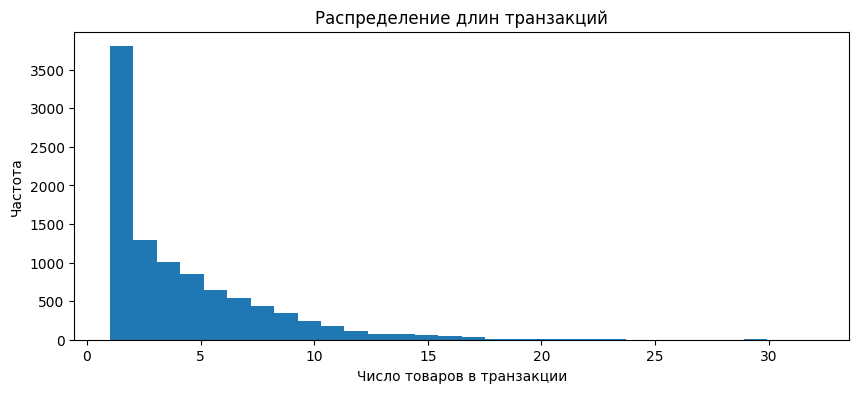

Число уникальных товаров: 169
Топ-20 самых частых товаров:
whole milk: 2513
other vegetables: 1903
rolls/buns: 1809
soda: 1715
yogurt: 1372
bottled water: 1087
root vegetables: 1072
tropical fruit: 1032
shopping bags: 969
sausage: 924
pastry: 875
citrus fruit: 814
bottled beer: 792
newspapers: 785
canned beer: 764
pip fruit: 744
fruit/vegetable juice: 711
whipped/sour cream: 705
brown bread: 638
domestic eggs: 624


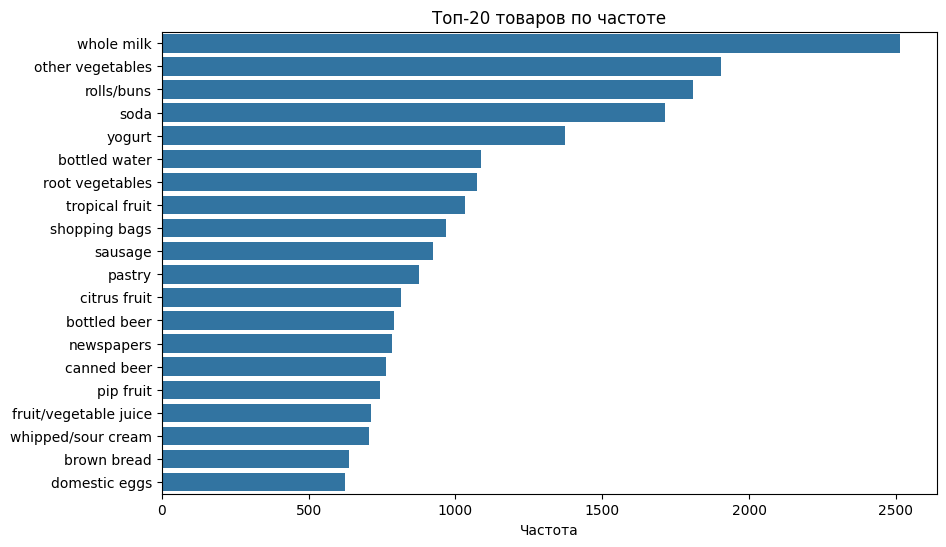

In [34]:
tran_lens = [len(t) for t in transactions]

plt.figure(figsize=(10,4))
plt.hist(tran_lens, bins=30)
plt.title('Распределение длин транзакций')
plt.xlabel('Число товаров в транзакции')
plt.ylabel('Частота')
plt.show()

all_items = [item for t in transactions for item in t]
item_counts = Counter(all_items)
n_unique = len(item_counts)
print(f'Число уникальных товаров: {n_unique}')
print('Топ-20 самых частых товаров:')
for item, cnt in item_counts.most_common(20):
    print(f'{item}: {cnt}')

top20 = item_counts.most_common(20)
items = [x[0] for x in top20]
counts = [x[1] for x in top20]
plt.figure(figsize=(10,6))
sns.barplot(x=counts, y=items)
plt.title('Топ-20 товаров по частоте')
plt.xlabel('Частота')
plt.show()

На графиках изображены распределение длин транзакций и топ-20 самых частых товаров.

#### Очистка и подготовка данных

In [35]:
#Очистка данных
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

#Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(len(unique_items),unique_items)

159 {'semi-finished bread', 'pudding powder', 'kitchen towels', 'onions', 'frozen fish', 'pastry', 'frozen potato products', 'decalcifier', 'organic sausage', 'cling film/bags', 'chocolate', 'dog food', 'zwieback', 'fish', 'liver loaf', 'meat', 'sugar', 'syrup', 'bottled beer', 'waffles', 'rolls/buns', 'yogurt', 'nuts/prunes', 'Instant food products', 'sparkling wine', 'abrasive cleaner', 'citrus fruit', 'processed cheese', 'canned beer', 'soups', 'coffee', 'fruit/vegetable juice', 'prosecco', 'tea', 'cookware', 'light bulbs', 'pot plants', 'artif. sweetener', 'finished products', 'potato products', 'tidbits', 'specialty bar', 'hygiene articles', 'pasta', 'baby cosmetics', 'organic products', 'grapes', 'dental care', 'specialty cheese', 'chewing gum', 'spices', 'roll products ', 'flower soil/fertilizer', 'jam', 'margarine', 'packaged fruit/vegetables', 'skin care', 'pickled vegetables', 'male cosmetics', 'cleaner', 'soda', 'flower (seeds)', 'white wine', 'bottled water', 'soap', 'canne

In [36]:
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)
data.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baking powder,bathroom cleaner,beef,berries,beverages,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Алгоритм FPG с начальными параметрами из задания

In [37]:
df_fpg = fpgrowth(data, min_support=0.002, use_colnames=True)
df_fpg

,support,itemsets
0,0.033743,(yogurt)
1,0.020966,(coffee)
2,0.010156,(cream cheese )
3,0.054709,(whole milk)
4,0.013432,(long life bakery product)
...,...,...
130,0.002948,"(root vegetables, whole milk)"
131,0.002457,"(root vegetables, other vegetables)"
132,0.002293,"(margarine, whole milk)"
133,0.002293,"(red/blush wine, liquor)"


In [38]:
rules_fpg = association_rules(df_fpg, metric="confidence", min_threshold=0.13)
rules_fpg

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(rolls/buns),(soda),0.074693,0.079607,0.009828,0.131579,1.652859,1.0,0.003882,1.059847,0.426872,0.068027,0.056467,0.127518
1,(chocolate),(rolls/buns),0.018346,0.074693,0.002457,0.133929,1.793057,1.0,0.001087,1.068396,0.450559,0.027125,0.064017,0.083412
2,(bottled water),(soda),0.039967,0.079607,0.005405,0.135246,1.698922,1.0,0.002224,1.064341,0.428518,0.047346,0.060451,0.101574
3,(other vegetables),(whole milk),0.040786,0.054709,0.005897,0.144578,2.642666,1.0,0.003665,1.105058,0.648025,0.065814,0.095070,0.126181
4,(curd),(whole milk),0.010319,0.054709,0.002621,0.253968,4.642144,1.0,0.002056,1.267092,0.792763,0.041995,0.210791,0.150936
5,(whipped/sour cream),(whole milk),0.015725,0.054709,0.002129,0.135417,2.475206,1.0,0.001269,1.093348,0.605515,0.031175,0.085378,0.087169
6,(whipped/sour cream),(yogurt),0.015725,0.033743,0.002785,0.177083,5.248028,1.0,0.002254,1.174186,0.822384,0.059649,0.148346,0.129804
7,(waffles),(soda),0.013268,0.079607,0.002129,0.160494,2.016080,1.0,0.001073,1.096351,0.510765,0.023466,0.087883,0.093621
8,(root vegetables),(whole milk),0.013759,0.054709,0.002948,0.214286,3.916809,1.0,0.002196,1.203097,0.755079,0.045000,0.168812,0.134089
9,(root vegetables),(other vegetables),0.013759,0.040786,0.002457,0.178571,4.378227,1.0,0.001896,1.167738,0.782362,0.047170,0.143644,0.119406


##### Анализ правил, полученных FPGrowth. 
1. (liquor и bottled beer)  confidence = 0.30 - в 30% случаев, когда покупают алкоголь, покупают бутылочное пиво. lift = 7.96 - очень сильная, неслучайная взаимосвязь.
2. (curd и whole milk) confidence = 0.25 lift = 4.64 Покупатели творога очень часто покупают и молоко.
3. (whipped/sour cream и yogurt) confidence = 0.17 lift = 5.24 средняя доверенность, высокая степень связи
4. (other vegetables и whole milk) confidence ≈ 0.14 lift = 2.64
5. (rolls/buns и soda) confidence ≈ 0.13 lift = 1.65 Покупатели булочек иногда покупают напитки.

### Алгоритм Apriori

In [39]:
df_ap = apriori(data, min_support=0.002, use_colnames=True)
df_ap

,support,itemsets
0,0.002293,(Instant food products)
1,0.006880,(UHT-milk)
2,0.003276,(baking powder)
3,0.003604,(beef)
4,0.002785,(berries)
...,...,...
130,0.002129,"(soda, waffles)"
131,0.002948,"(soda, whole milk)"
132,0.002129,"(whipped/sour cream, whole milk)"
133,0.002785,"(yogurt, whipped/sour cream)"


In [40]:
rules_ap = association_rules(df_ap, metric="confidence", min_threshold=0.13)
rules_ap

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(liquor),(bottled beer),0.008190,0.037674,0.002457,0.300000,7.963043,1.0,0.002148,1.374751,0.881641,0.056604,0.272596,0.182609
1,(bottled water),(soda),0.039967,0.079607,0.005405,0.135246,1.698922,1.0,0.002224,1.064341,0.428518,0.047346,0.060451,0.101574
2,(chocolate),(rolls/buns),0.018346,0.074693,0.002457,0.133929,1.793057,1.0,0.001087,1.068396,0.450559,0.027125,0.064017,0.083412
3,(curd),(whole milk),0.010319,0.054709,0.002621,0.253968,4.642144,1.0,0.002056,1.267092,0.792763,0.041995,0.210791,0.150936
4,(red/blush wine),(liquor),0.011302,0.008190,0.002293,0.202899,24.773913,1.0,0.002201,1.244271,0.970605,0.133333,0.196316,0.241449
5,(liquor),(red/blush wine),0.008190,0.011302,0.002293,0.280000,24.773913,1.0,0.002201,1.373191,0.967559,0.133333,0.271769,0.241449
6,(root vegetables),(other vegetables),0.013759,0.040786,0.002457,0.178571,4.378227,1.0,0.001896,1.167738,0.782362,0.047170,0.143644,0.119406
7,(other vegetables),(whole milk),0.040786,0.054709,0.005897,0.144578,2.642666,1.0,0.003665,1.105058,0.648025,0.065814,0.095070,0.126181
8,(rolls/buns),(soda),0.074693,0.079607,0.009828,0.131579,1.652859,1.0,0.003882,1.059847,0.426872,0.068027,0.056467,0.127518
9,(root vegetables),(whole milk),0.013759,0.054709,0.002948,0.214286,3.916809,1.0,0.002196,1.203097,0.755079,0.045000,0.168812,0.134089


##### Анализ правил, полученных FPGrowth. 
Таблица Apriori содержит аналогичные правила, но немного в другом порядке и с другими комбинациями. Оба алгоритма дают похожие правила, но Apriori чаще ловит менее значимые, с меньшим лифтом.

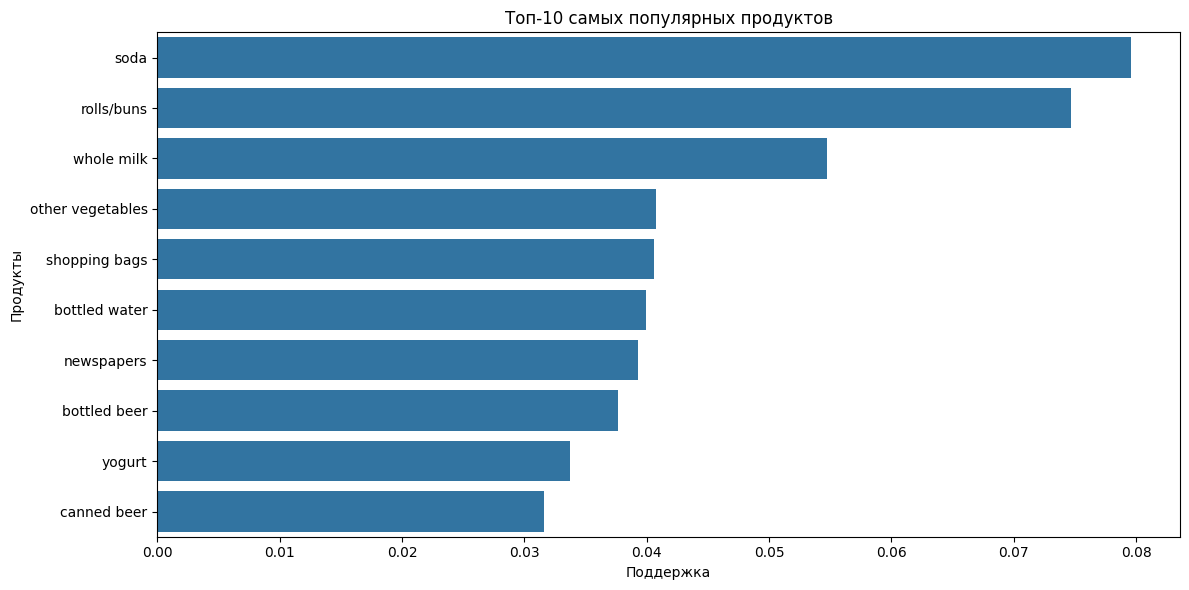

In [41]:
df_fpg_sorted = df_fpg.copy()
df_fpg_sorted['itemsets'] = df_fpg_sorted['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df_fpg_sorted.sort_values(by='support', ascending=False).head(10)
top_products

plt.figure(figsize=(12,6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title("Топ-10 самых популярных продуктов")
plt.xlabel("Поддержка")
plt.ylabel("Продукты")
plt.tight_layout()
plt.show()

In [42]:
rules_fpg2 = rules_fpg.copy()
rules_fpg2['antecedents'] = rules_fpg2['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_fpg2['consequents'] = rules_fpg2['consequents'].apply(lambda x: ', '.join(list(x)))

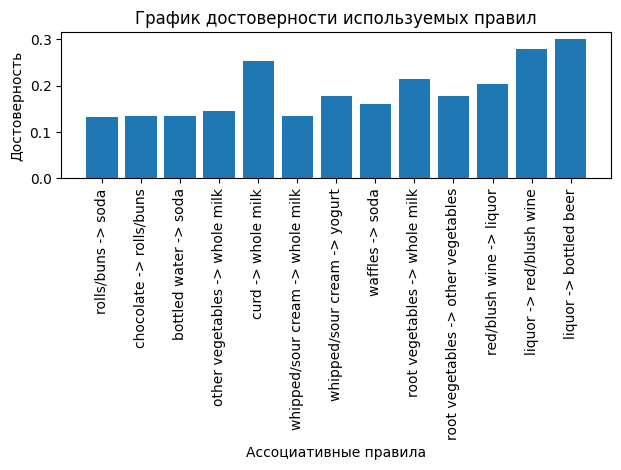

In [43]:
#График достоверности используемых правил
products_1 = rules_fpg2["antecedents"].tolist()
products_2 = rules_fpg2["consequents"].tolist()
confidence = rules_fpg2["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

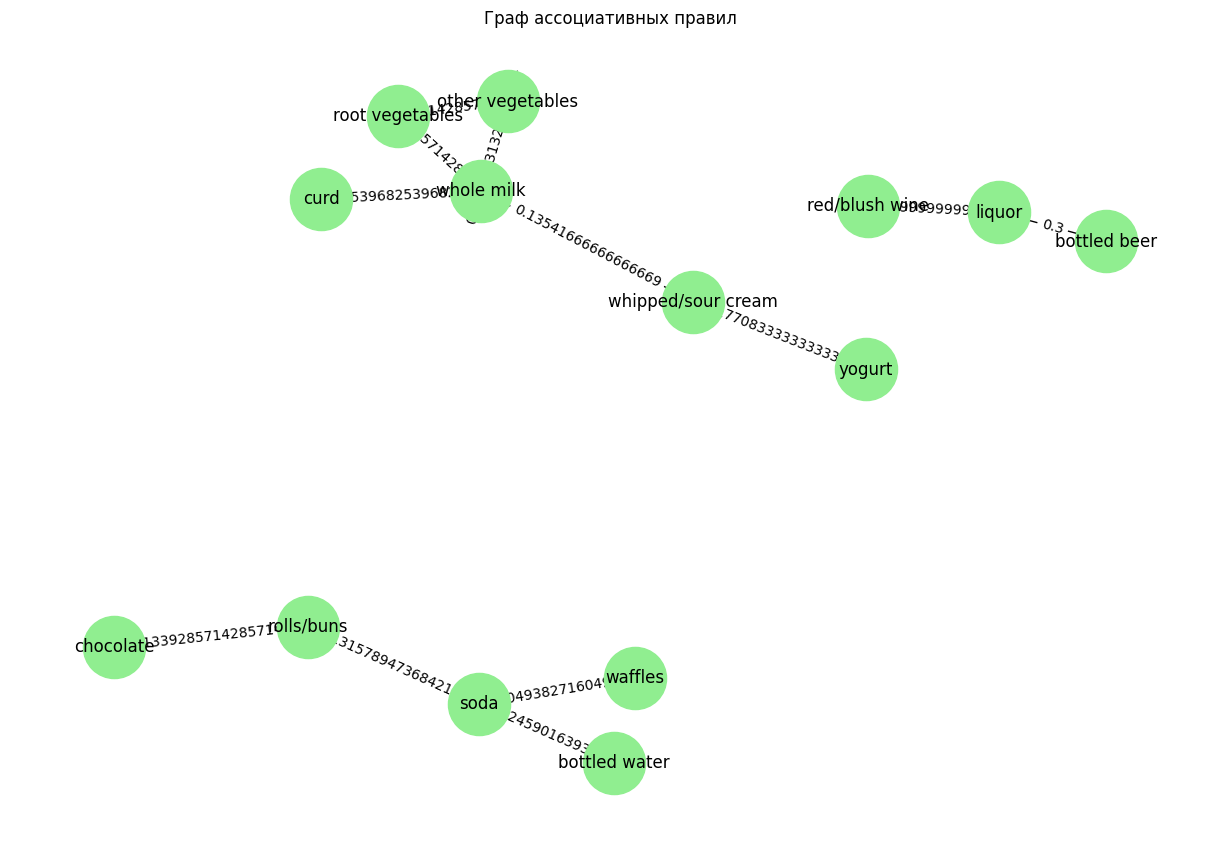

In [44]:
G = nx.Graph()

for idx, row in rules_fpg2.iterrows():
    G.add_node(row['antecedents'])
    G.add_node(row['consequents'])
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])

pos = nx.spring_layout(G)

plt.figure(figsize=(12,8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightgreen")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Граф ассоциативных правил")
plt.show()


In [45]:
import numpy as np
from mlxtend.frequent_patterns import apriori

def find_min_supports(data, max_k=5):
    supports = np.linspace(0.15, 0.001, 60)  # 60 шагов от 0.15 до 0.001
    mins = {k: None for k in range(1, max_k+1)}  # для k=1..max_k

    for sup in supports:
        df = apriori(data, min_support=sup, use_colnames=True)
        df["len"] = df["itemsets"].apply(lambda x: len(x))

        for k in range(1, max_k+1):
            if mins[k] is None and any(df["len"] == k):
                mins[k] = sup

    return mins

mins = find_min_supports(data, max_k=5)
mins

{1: np.float64(0.07928813559322034),
 2: np.float64(0.008576271186440693),
 3: np.float64(0.001),
 4: None,
 5: None}

Для каждого значения вычислялись частые наборы Apriori, определялась их длина, и фиксировался первый support, при котором встречались наборы длины k, что определило минимальные пороги поддержки для наборов из 1, 2, 3, 4 и 5 элементов. 
При минимальной поддержке в 0.001, в датасете нет устойчивых комбинаций из 4 и более товаров товаров

In [46]:
def test_params(min_sup, min_conf):
    df = apriori(data, min_support=min_sup, use_colnames=True)
    rules = association_rules(df, metric="confidence", min_threshold=min_conf)
    return len(df), len(rules)

params = [(0.002, 0.13), (0.05, 0.13), (0.02, 0.13), (0.001, 0.2), (0.001, 0.02), (0.001, 0.14), (0.001, 0.17),(0.02, 0.4)]
results = []

for sup, conf in params:
    results.append([sup, conf, *test_params(sup, conf)])

pd.DataFrame(results, columns=["support", "confidence", "freq_sets", "rules"])

,support,confidence,freq_sets,rules
0,0.002,0.13,135,13
1,0.050,0.13,3,0
2,0.020,0.13,14,0
3,0.001,0.20,230,11
4,0.001,0.02,230,203
5,0.001,0.14,230,28
6,0.001,0.17,230,15
7,0.020,0.40,14,0


При у меньшении min_support растёт количество частых наборов, количество правил появляются малозначимые правила.

При увеличении min_support остаются самые популярные товары

C:\Users\Днс\AppData\Local\Temp\ipykernel_8608\102958463.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = rules_fpg2.pivot_table(


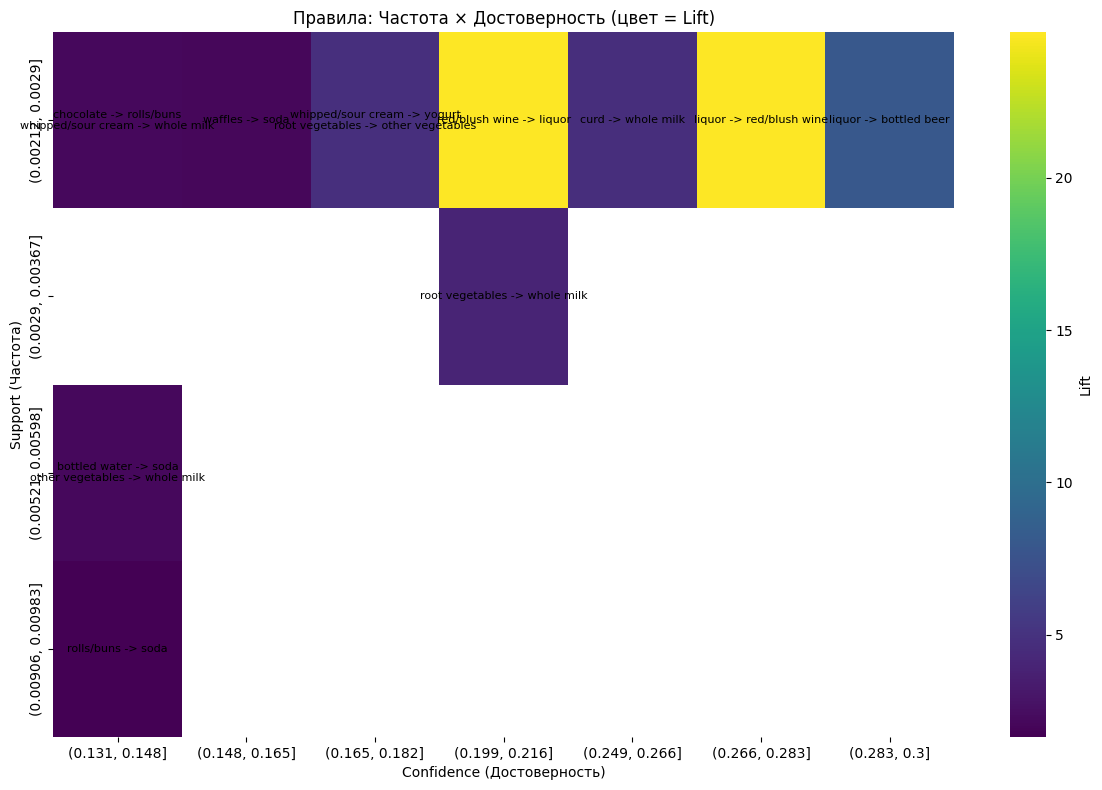

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


rules_fpg2['rule'] = rules_fpg2['antecedents'].astype(str) + " -> " + rules_fpg2['consequents'].astype(str)

rules_fpg2['support_bin'] = pd.cut(rules_fpg2['support'], bins=10)
rules_fpg2['confidence_bin'] = pd.cut(rules_fpg2['confidence'], bins=10)

heatmap_data = rules_fpg2.pivot_table(
    index='support_bin',
    columns='confidence_bin',
    values='lift',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=False,  
    cbar_kws={'label': 'Lift'}
)

for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        mask = (
            (rules_fpg2['support_bin'] == heatmap_data.index[i]) &
            (rules_fpg2['confidence_bin'] == heatmap_data.columns[j])
        )
        rules_in_cell = rules_fpg2.loc[mask, 'rule']
        if not rules_in_cell.empty:
            text = '\n'.join(rules_in_cell)
            ax.text(
                j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black', fontsize=8  # черный цвет текста
            )
plt.title("Правила: Частота × Достоверность (цвет = Lift)")
plt.xlabel("Confidence (Достоверность)")
plt.ylabel("Support (Частота)")
plt.tight_layout()
plt.show()

### Заключение

В работе были изучены методы анализа ассоциативных правил, рассмотрены алгоритмы Apriori и FP-Growth, выполнена визуализация результатов и анализ влияния параметров алгоритмов на метрики.
Полученные ассоциативные правила позволяют выявить закономерности совместной покупки товаров, что может применяться в рекомендационных системах и маркетинговом анализе.